# Imports

In [131]:
# Basic libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn utilities
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Scikit-learn model selection tools
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict

# Scikit-learn classifiers
from sklearn.ensemble import RandomForestClassifier

# Scikit-learn preprocessing tools
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

# Scikit-learn metrics and evaluation tools
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.inspection import permutation_importance

# Custom utilities
from awesometel.utils import read

In [132]:
sns.set_theme()

# Raw data

In [133]:
df_raw_accounts = read("inp_awesometel__accounts", schema="dev_input")
df_raw_interactions = read("inp_awesometel__interactions", schema="dev_input")
df_raw_product_holdings = read("inp_awesometel__product_holdings", schema="dev_input")

df_raw_interactions["customer_satisfaction_after_call"].unique()

array([nan,  5.,  1.,  2.,  4.,  3.])

In [134]:
print(df_raw_interactions.describe().to_markdown())
print(df_raw_accounts.describe().to_markdown())
print(df_raw_product_holdings.describe().to_markdown())

|       |   account_id | date                          |   time_in_queue |   handling_time_s |   customer_satisfaction_after_call |
|:------|-------------:|:------------------------------|----------------:|------------------:|-----------------------------------:|
| count |     14690    | 14690                         |      14690      |        14690      |                         8847       |
| mean  |      5505.46 | 2023-02-25 02:07:26.017699328 |         30.0248 |           80.0433 |                            3.56369 |
| min   |      1000    | 2021-01-07 00:00:00           |          3      |           17      |                            1       |
| 25%   |      3270    | 2022-05-18 00:00:00           |         17      |           44      |                            2       |
| 50%   |      5519.5  | 2023-02-21 00:00:00           |         28      |           80      |                            4       |
| 75%   |      7737.5  | 2023-11-07 00:00:00           |         40      |  

# Load data from DB and quick EDA

In [135]:
df_churn = read("churns", schema="dev_marts")

<Axes: xlabel='is_churned', ylabel='count'>

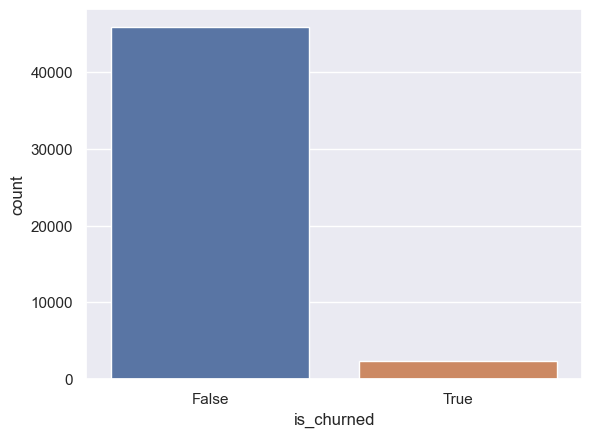

In [136]:
sns.countplot(df_churn, x="is_churned")

In [137]:
def analyze_numerical_feature(df, target, feature):
    plt.clf()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Feature: {feature}")
    sns.barplot(data=df, x=target, y=feature, ax=axes[0])
    sns.boxplot(data=df, x=target, y=feature, ax=axes[1])
    sns.stripplot(data=df, x=target, y=feature, ax=axes[2])
    plt.show()
    

def analyze_categorical_feature(df, target, feature):
    plt.clf()
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    fig.suptitle(f"Feature: {feature}")
    sns.histplot(data=df, x=feature, hue=target, stat="percent", common_norm=False, multiple="dodge", ax=axes)
    plt.show()
                                                  

## Univariate numerical features analysis

<Figure size 640x480 with 0 Axes>

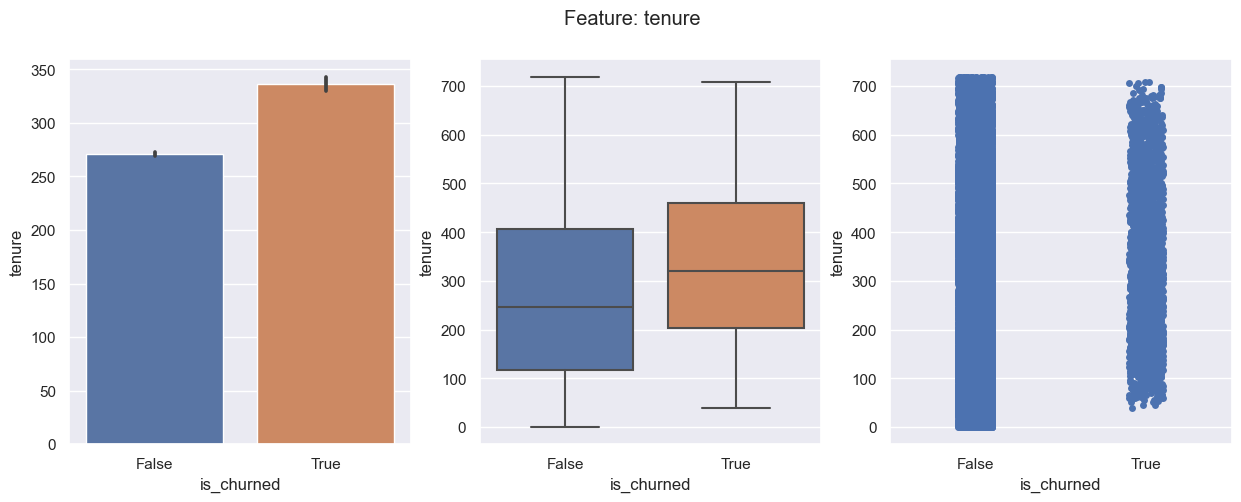

<Figure size 640x480 with 0 Axes>

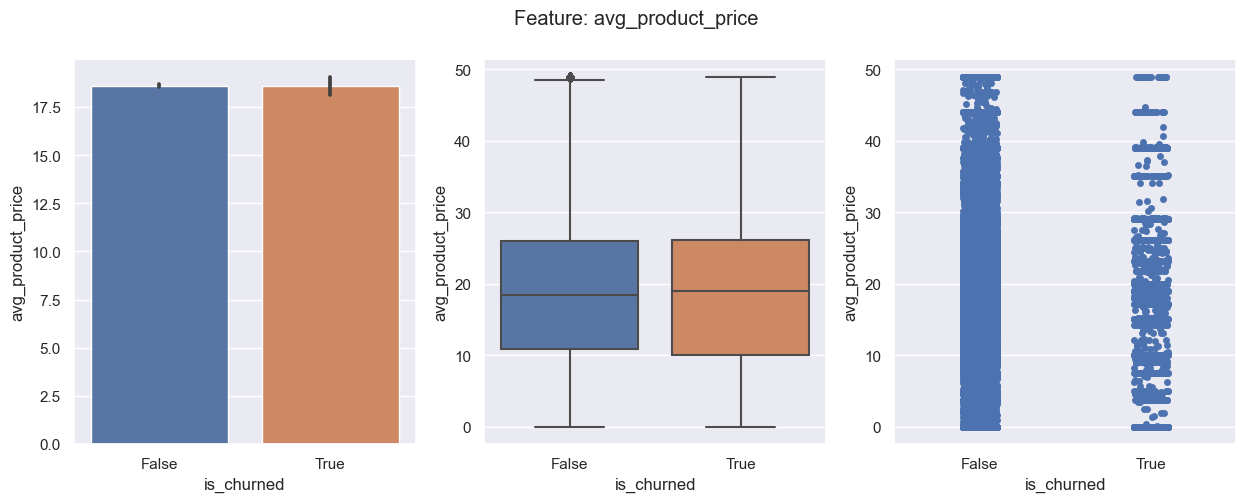

<Figure size 640x480 with 0 Axes>

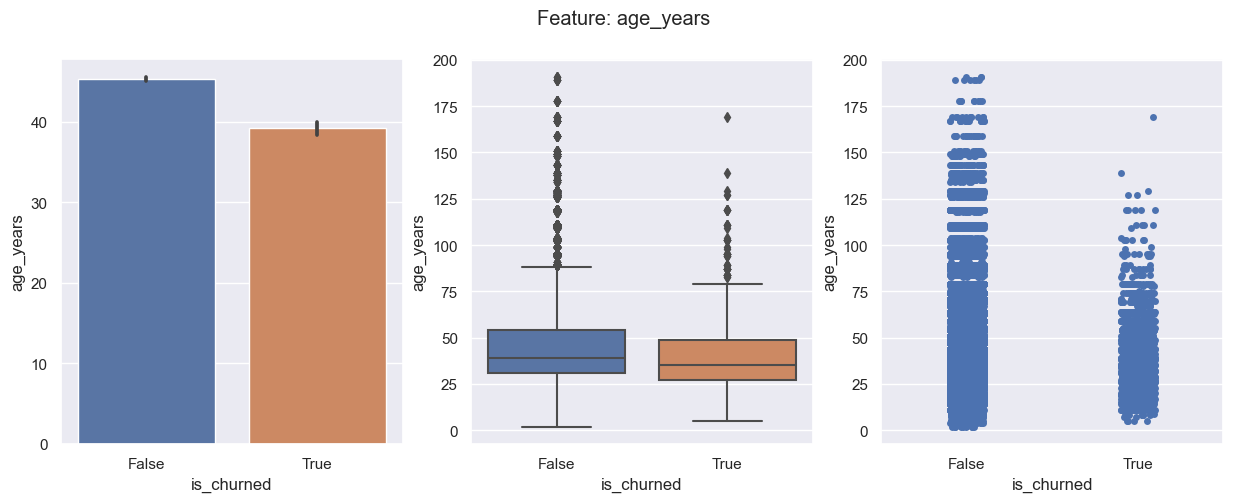

<Figure size 640x480 with 0 Axes>

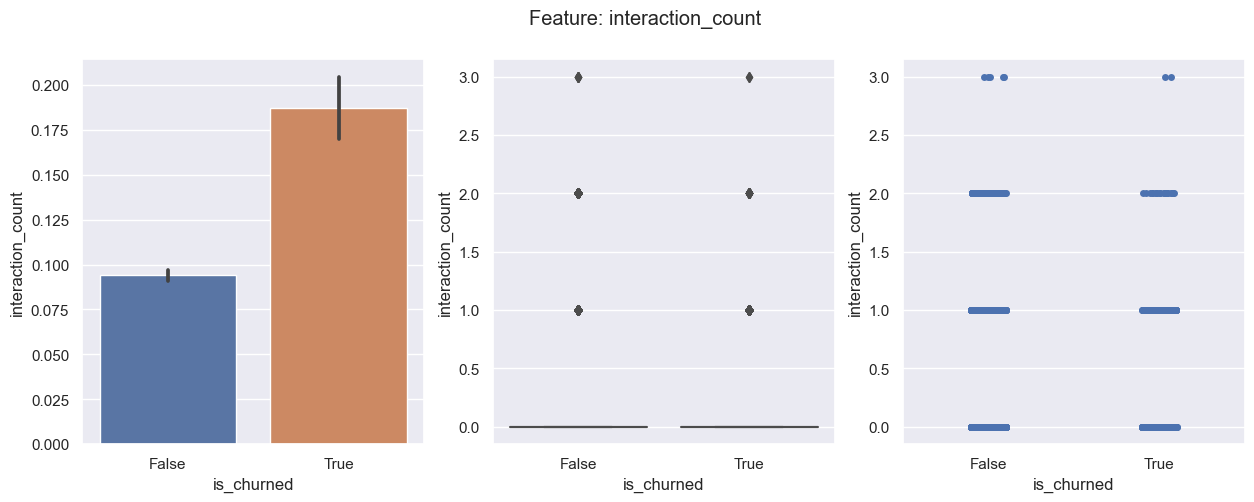

<Figure size 640x480 with 0 Axes>

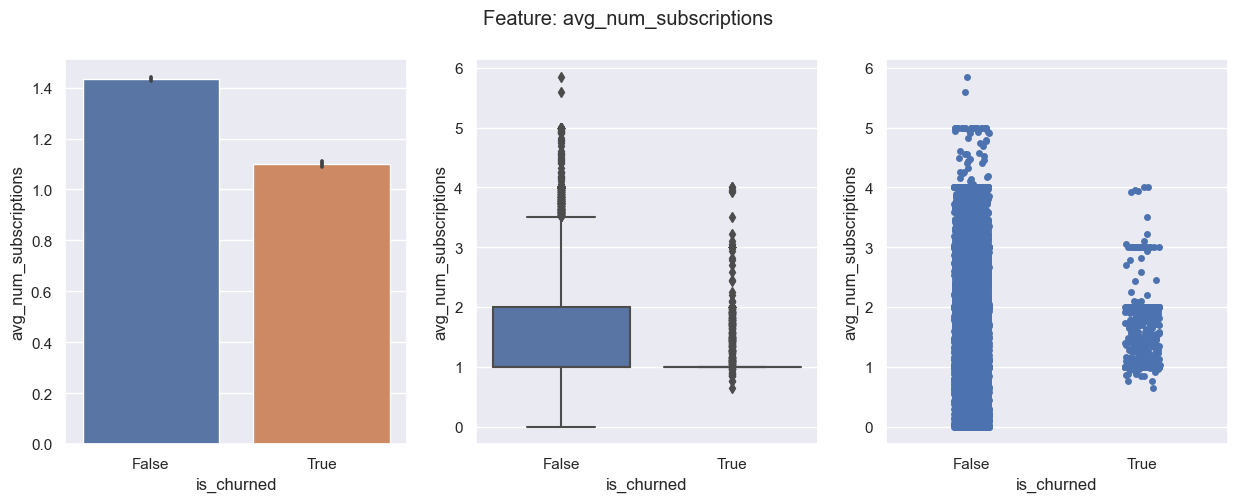

In [138]:
analyze_numerical_feature(df_churn, "is_churned", "tenure")
analyze_numerical_feature(df_churn, "is_churned", "avg_product_price")
analyze_numerical_feature(df_churn, "is_churned", "age_years")
analyze_numerical_feature(df_churn, "is_churned", "interaction_count")
analyze_numerical_feature(df_churn, "is_churned", "avg_num_subscriptions")

## Univariate categorical features analysis

<Figure size 640x480 with 0 Axes>

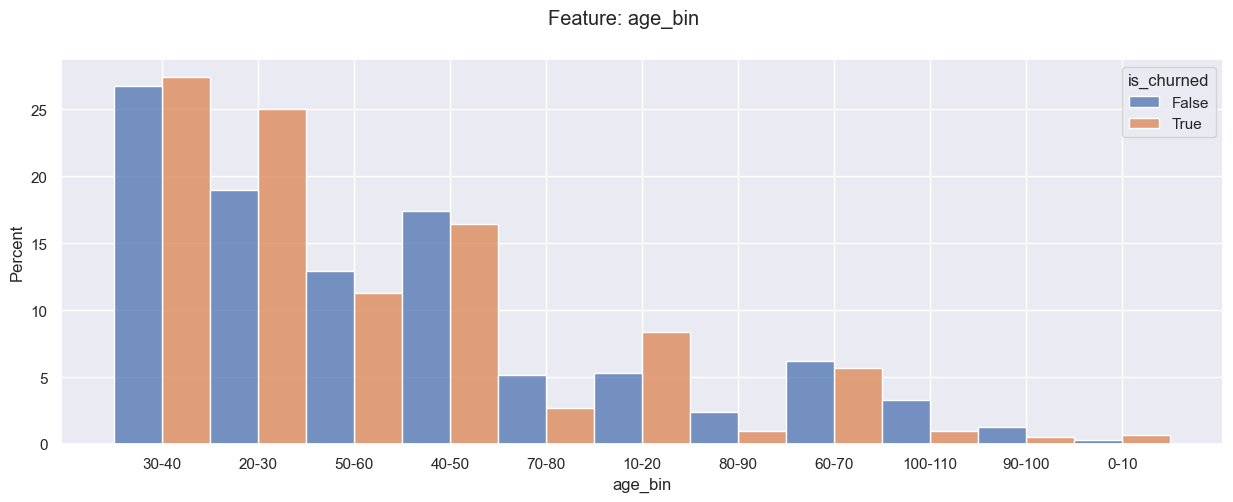

<Figure size 640x480 with 0 Axes>

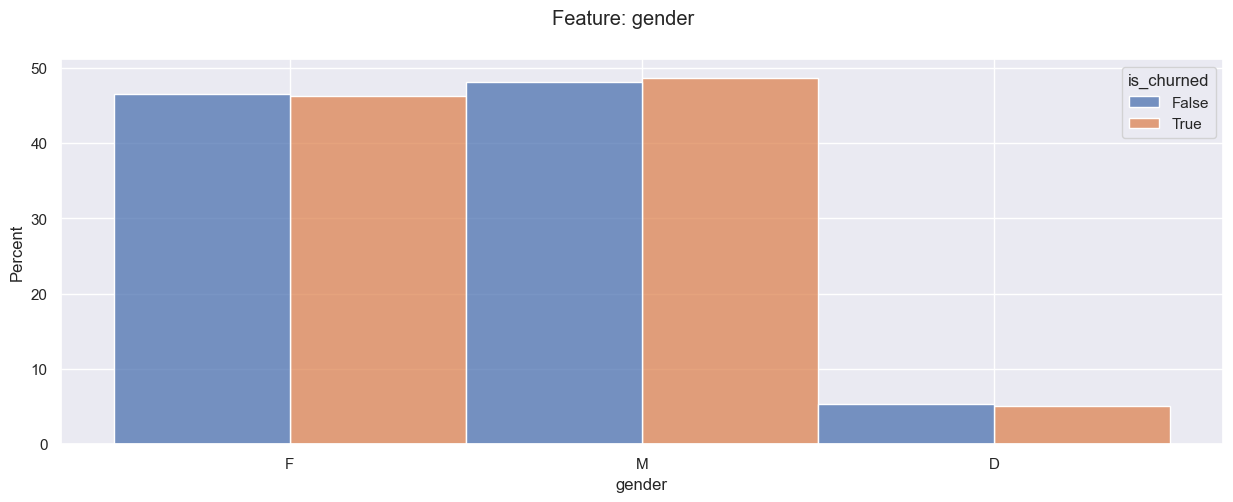

<Figure size 640x480 with 0 Axes>

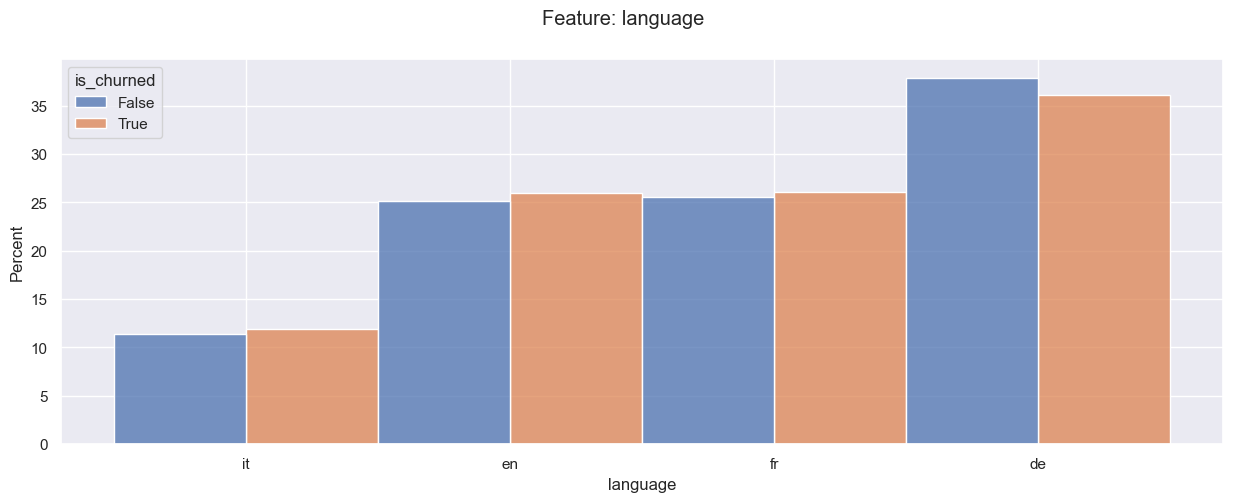

<Figure size 640x480 with 0 Axes>

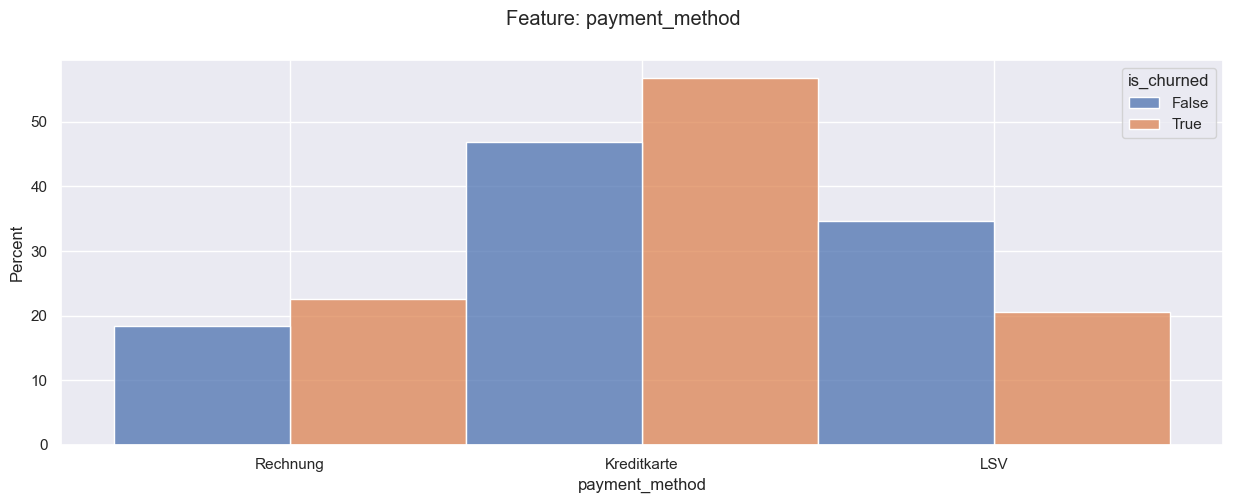

In [139]:
analyze_categorical_feature(df_churn, "is_churned", "age_bin")
analyze_categorical_feature(df_churn, "is_churned", "gender")
analyze_categorical_feature(df_churn, "is_churned", "language")
analyze_categorical_feature(df_churn, "is_churned", "payment_method")

# Training a simple model

In [168]:
SEED = 7

# Downsample to have a balanced dataset based on the is_churned label
def downsample(df):
    # set numpy seed
    np.random.seed(SEED)

    churner_ids = df.query("is_churned == True")["account_id"]

    # first downsample the churners per user_id
    non_churner_ids = df.query("is_churned == False")["account_id"].unique()
    non_churners_selected_ids = np.random.choice(non_churner_ids, len(churner_ids), replace=False)
    df = pd.concat([df.query("is_churned == True"), df[df["account_id"].isin(non_churners_selected_ids)]])

    one_entry_per_non_churner = df.query("is_churned == False").groupby("account_id").apply(lambda x: x.sample(1))
    one_entry_per_non_churner = one_entry_per_non_churner.reset_index(drop=True)
    df_balanced = pd.concat([df.query("is_churned == True"), one_entry_per_non_churner])

    
    assert len(df_balanced.query("is_churned == True")) == len(df_balanced.query("is_churned == False"))
    nunique_per_target = df_balanced.groupby("is_churned").agg({"account_id": "nunique"})
    assert nunique_per_target.loc[True, "account_id"] == len(churner_ids)
    assert nunique_per_target.loc[False, "account_id"] == len(non_churners_selected_ids)

    return df_balanced

    

df_churn_balanced = downsample(df_churn)

# Write an sklearn pipeline to cross_validate a random forest classifier on the balanced dataset



X = df_churn_balanced.drop("is_churned", axis=1)
y = df_churn_balanced["is_churned"]

# Define the columns you want to keep


# Columns to be label encoded
categorical_features = ["language", "gender", "zip_code", "payment_method", "age_bin"]
numerical_features = ["avg_product_price", "interaction_count", "avg_num_subscriptions", "tenure"]
X = X.loc[:, categorical_features + numerical_features]

# Building a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num_impute', SimpleImputer(strategy='constant', fill_value=0), numerical_features),
        ('cat_encode', OrdinalEncoder(), categorical_features),
    ],
    remainder='passthrough'  # Other columns remain unchanged
)

# Creating the pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=SEED))
])

# Cross-validating the pipeline
results = cross_validate(pipeline, X, y, cv=5, scoring=["f1", "recall", "precision"])

print("Average F1 score:", results["test_f1"].mean())
print("Average Recall:", results["test_recall"].mean())
print("Average Precision:", results["test_precision"].mean())

df_churn_balanced.head()


Average F1 score: 0.7858183475372661
Average Recall: 0.8351444092264828
Average Precision: 0.7422702853719765


,account_id,end_date,is_churned,client_since,avg_product_price,interaction_count,avg_handling_time,avg_satisfaction,avg_num_subscriptions,tenure,language,gender,birthday,zip_code,payment_method,age_years,age_bin
1,1462,2021-10-02,True,2021-07-11,17.1,0,NaN,NaN,1.0,83,en,M,1994-06-27,3005,Kreditkarte,29,20-30
17,1738,2022-11-18,True,2021-03-14,9.0,0,NaN,NaN,1.0,614,de,M,1987-09-12,6006,LSV,35,30-40
36,1548,2022-03-05,True,2021-01-19,49.0,1,39.0,4.0,1.0,410,None,M,1996-04-27,3005,Rechnung,27,20-30
47,1566,2022-01-25,True,2021-03-25,7.5,0,NaN,NaN,1.0,306,fr,M,1983-10-05,5005,Kreditkarte,39,30-40
85,1400,2022-07-06,True,2021-08-26,0.0,0,NaN,NaN,1.0,314,en,F,1963-10-17,9102,Rechnung,59,50-60


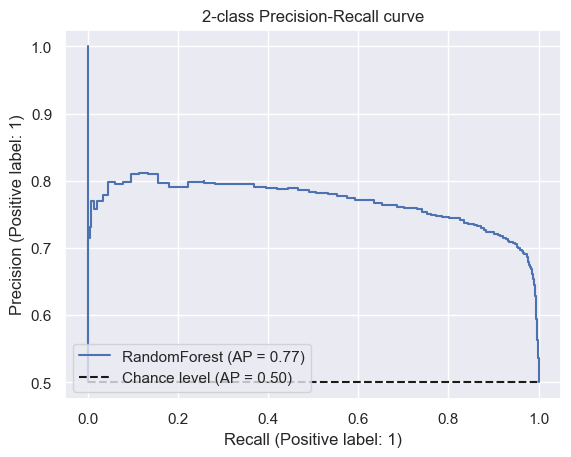

In [159]:
# Assuming you're using a classifier clf and data X, y
predicted_scores = cross_val_predict(pipeline, X, y, cv=5, method="predict_proba")[:, 1]

display = PrecisionRecallDisplay.from_predictions(y, predicted_scores, name="RandomForest", plot_chance_level=True)
_ = display.ax_.set_title("2-class Precision-Recall curve")

/var/folders/3y/fmdcnnys28147_k97yh_db940000gn/T/ipykernel_82070/1400677063.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_importances, y='features', x='importance_value', hue='importance_type', ci=None)


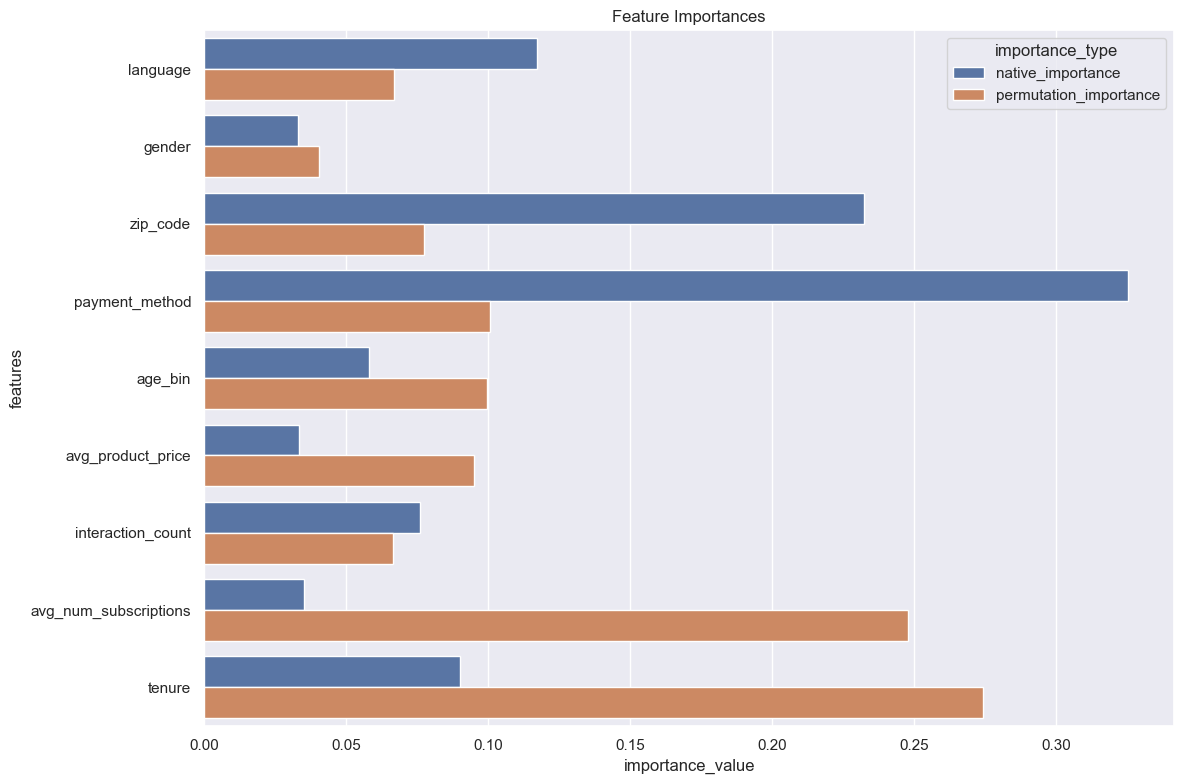

In [169]:
pipeline.fit(X, y)

clf = pipeline.named_steps['classifier']
importances_native = clf.feature_importances_



result = permutation_importance(pipeline, X, y, n_repeats=30, random_state=SEED)
importances_permutation = result.importances_mean




df_importances = pd.DataFrame({
    'features': X.columns,
    'native_importance': importances_native,
    'permutation_importance': importances_permutation
}).melt(id_vars='features', var_name='importance_type', value_name='importance_value')



plt.figure(figsize=(12, 8))
sns.barplot(data=df_importances, y='features', x='importance_value', hue='importance_type', ci=None)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

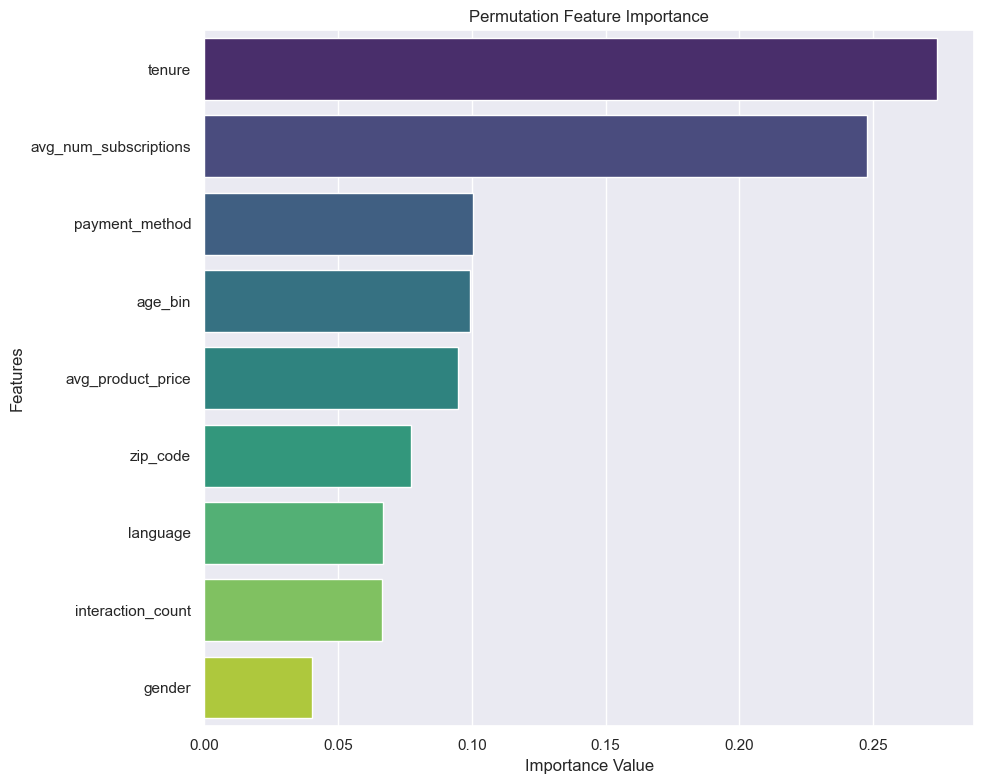

In [170]:
# Filter for only permutation importance
perm_importances = df_importances[df_importances['importance_type'] == 'permutation_importance']

# Sort by importance value
perm_importances_sorted = perm_importances.sort_values(by='importance_value', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=perm_importances_sorted, y='features', x='importance_value', palette='viridis')
plt.title("Permutation Feature Importance")
plt.xlabel("Importance Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [ ]:
# Explain that we need to scale the data before we can use it in a model